## Tides on a randomly vegetated field

In this notebook we will be running the [Landlab](http://landlab.github.io/#/) tidal-flow-calculator over a randomly generated field of vegetation (simulated by 2 Mannings Roughness values) and looking at how passive particle transport is impacted by the spatial distribution of plants.

### Importing and Installing

First we will import some standard scientific Python libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Next we need to install some libraries (including Landlab) to properly accomplish this task.

As of this writing (8/18/2020) the tidal-flow-calculator is not part of the core Landlab installation. As a consequence, we need to checkout the feature branch containing the tidal-flow-calculator component (https://github.com/landlab/landlab/tree/gt/tidal-flow-component). After checking out or cloning this branch locally, `python setup.py install` should be run to build a new landlab installation containing the tidal-flow-calculator.

To build random fields of different characteristic length scales, we will use the geostatistical toolbox [GSTools](https://github.com/GeoStat-Framework/GSTools). To install this package, the command `conda install gstools` can be run from the command line. In this example we will be using a standard covariance model for random field generation. 

Lastly, to simulate passive particle transport we will use the Lagrangian-based transport model [dorado](https://github.com/passaH2O/dorado). To install dorado we can type `pip install pydorado` from the command line.

In [2]:
from landlab.components import TidalFlowCalculator
from landlab import RasterModelGrid
from landlab.grid.mappers import map_max_of_link_nodes_to_link
from dorado.routines import plot_state
import gstools as gs

Lastly there are some custom scripts containing functions we want to use for this example. These scripts are available in the same directory as this notebook, and so our imports will be happening locally.

In [3]:
from map_fun import gridded_vars
from plot_fun import group_plot
from plot_fun import plot_depth
from particletransport import init_particles
from particletransport import tidal_particles

### Model Parameters

We are going to create model parameters that define the tidal scenario for the tidal-flow-calculator as well as the random field properties.

First we will define the size of the domain (which is going to be a square) as well as the grid spacing, mean water depth, and properties associated with the tide. Two roughness values are going to be specified, a low and high roughness to represent low and high vegetation density.

In [4]:
nrows = 250
ncols = nrows
grid_spacing = 1.0  # m
mean_depth = 1.5  # m
tidal_range = 0.5  # m
roughness_low = 0.01  # s/m^1/3, i.e., Manning's n
roughness_high = 0.1  # s/m^1/3, i.e., Manning's n
tide_period = 2*60*60  # tidal period in seconds
n_tide_periods = 10  # number of tidal periods to move particles around for
Np_tracer = 100 # number of passive particles to use

We also need to define properties of the random field. The two values of importance here are the `seed` which defines the random seed that is used (can be nice for reproducability) and the value `len_scale` which specifies the length scale of the features. `len_scale` is an integer for an isotropic field, but can be a list (e.g. `[5, 10]`) to create an anisotropic field.

In [5]:
seed = 1  # defines the random seed
len_scale = 10  # length scale - integer = isotropic; list [1, 5] = anisotropic

### Generating a random field

Now we will be generating a random field based on the `seed` and `len_scale` parameters defined above.

In [6]:
x = y = range(nrows)
model = gs.Gaussian(dim=2, var=1, len_scale=len_scale)
srf = gs.SRF(model, seed=seed)
srf.structured([x, y])
gs.transform.binary(srf)
# get array info from srf object
srf_array = srf.field

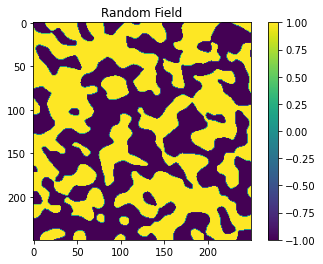

In [7]:
# Let's visualize this random field
plt.figure()
plt.imshow(srf_array)
plt.colorbar()
plt.title('Random Field')
plt.show()

### Defining the Landlab Grid

Next we are going to be defining the Landlab grid object and its associated parameters. This is where we will be passing in the roughness values as dictated by the random field. In areas where the random field values exceed 0, the roughness will be high, and in areas where the random field values are negative the roughness will be low.

*Note:* We are defining a domain in which the top and bottom boundaries are open and the left and right boundaries are closed. You can modify this by changing the True/False values!

In [8]:
# create and set up the grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=grid_spacing)
z = grid.add_zeros('topographic__elevation', at='node')
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)

# set up roughness field (calculate on nodes, then map to links)
roughness_at_nodes = np.zeros_like(z)
roughness_at_nodes[srf_array.flatten() > 0] = roughness_high  # high roughness
roughness_at_nodes[srf_array.flatten() < 0] = roughness_low  # low roughness
roughness = grid.add_zeros('roughness', at='link')
map_max_of_link_nodes_to_link(grid, roughness_at_nodes, out=roughness)

array([ 0.01,  0.01,  0.01, ...,  0.01,  0.01,  0.01])

### Instantiate the TidalFlowCalculator and run it

In [9]:
# instantiate the TidalFlowCalculator
tfc = TidalFlowCalculator(grid, tidal_range=tidal_range,
                          tidal_period=tide_period, roughness='roughness')

# run it
tfc.run_one_step()

### Initialize the particles and run them

In [10]:
# get gridded values
gvals = gridded_vars(grid)

# initialize the particle parameters
# particles will be placed in center of domain
center_region = list(range(int(nrows/2-10), int(nrows/2+10)))
seed_xloc = center_region
seed_yloc = center_region
params = init_particles(seed_xloc, seed_yloc, Np_tracer, grid_spacing, gvals)

In [11]:
%%capture
# move the particles with the tides
walk_data = tidal_particles(params, tide_period/10, n_tide_periods,
                            plot_grid=np.flipud(np.reshape(roughness_at_nodes,
                                                           grid.shape)))

### Make visualizations

First we will visualize the velocity components of the ebb and flood tides. Then we will plot the particle locations at beginning and end of the simulation.

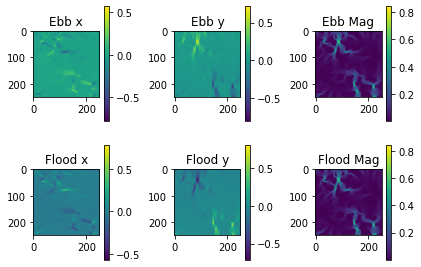

In [12]:
# plot velocity information
group_plot(gvals)
plt.show()

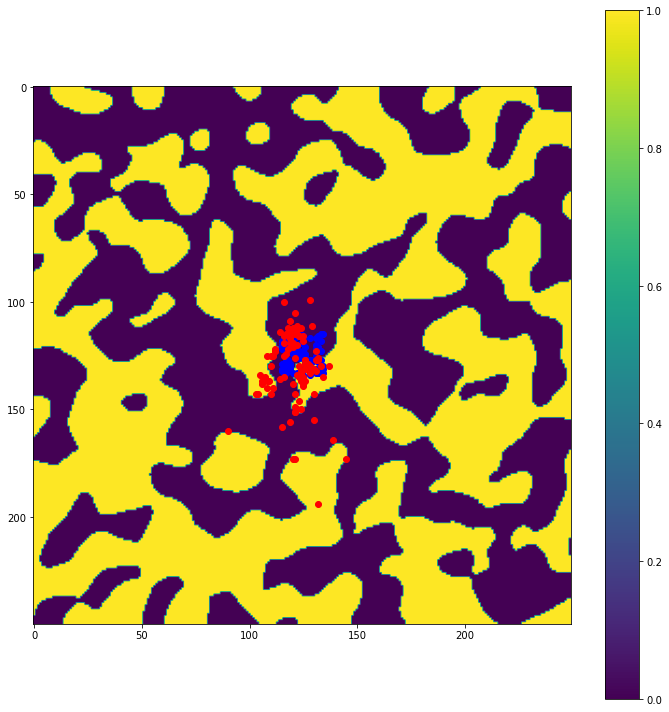

In [13]:
# plot particle locations on the roughness field
plt.figure(figsize=(10, 10))
# first plot initial locations as blue dots
plot_state(np.flipud(np.reshape(roughness_at_nodes,grid.shape)), 
           walk_data, iteration=0, target_time=None, c='b')
# then plot final locations as red dots
plot_state(np.flipud(np.reshape(roughness_at_nodes,grid.shape)), 
           walk_data, iteration=-1, target_time=None, c='r')
# make the colorbar - yellow for high roughness, purple for low
plt.colorbar()
# tighten layout
plt.tight_layout()
# show it
plt.show()

### Other Outpus, Gifs and More

In this example we only ran the module for 10 tidal cycles. If instead we ran it for 50 tidal cycles and captured the particle position after each ebb/flood tide, we could create the following video:

![50_Tidal_Cycles_gif](imgs/random_field/demo_len_scale_10.gif)

We can also examine cases where the length scale of the features in the random field is changed, if we reduce the feature size then the particles are impeded less often and can travel further. Let's take a look at what happens when the feature length scale is reduced from `len_scale=10` to `len_scale=5`:

![len_scale_05_gif](imgs/random_field/demo_len_scale_05.gif)

Now we can see that some particles make it to the edge of the domain, where we might say they 'leave' the area of study. This is a quick and dirty demonstration of how the spatial locations and spread of vegetation impacts the transport of nutrients and materials under the imposition of tidal flows.